# Tutorial: Using `fastai.data` low-level APIs

> Using `DataSource`, `Pipeline`, `TfmdList`, `TfmOver`, and `Transform`

In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.transform import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

## Overview

In the second half of this page we'll look at complete examples of loading and using datasets using the `fastai.data` low-level APIs. But first, let's look at simple examples of the following applied to a single filename:

- `Transform`
- `Pipeline` to composes transforms

(We won't look at `TfmdList`, `TfmdDS` or `DataSource` in this initial overview since they require a full dataset. Have a look at the second half of the page for examples of those.)

### Transform

First we'll have a look at the basic steps using a single MNIST image.

Let's start with a filename, and see step by step how it can be converted in to a labelled image that can be displayed and used for modeling.

In [ ]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)
fn = items[0]; fn

PosixPath('/home/sgugger/git/fastai_dev/dev/data/mnist_tiny/train/3/8055.png')

We'll look at each `Transform` needed in turn. Here's how we can open an image file:

In [ ]:
img = PILImage.create(fn); img

Then create a `c*h*w` tensor:

In [ ]:
tconv = ToTensor()
img = tconv(img)
img.shape,type(img)

(torch.Size([3, 28, 28]), local.data.transform.TensorImage)

Now that's done, we can create our labels. First extracting the text label:

In [ ]:
lbl = parent_label(fn); lbl

'3'

And then converting to an int for modeling:

In [ ]:
tcat = Categorize(vocab=['3','7'])
lbl = tcat(lbl); lbl

0

We use `decode` to reverse transforms for display. Reversing the `Categorize` transform result in a class name we can display:

In [ ]:
lbld = tcat.decode(lbl)
lbld

'3'

### Pipeline

We can compose our image steps using `Pipeline`:

In [ ]:
pipe = Pipeline([PILImage.create,tconv])
img = pipe(fn)
img.shape

torch.Size([3, 28, 28])

A `Pipeline` can decode and show an item.

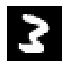

In [ ]:
pipe.show(img, figsize=(1,1), cmap='Greys');

The show method works behind the scenes with types. Transforms will make sure the type of an element they receive is preserved, or casted to the type in the return annotation. Here `PILImage.create` returns a `PILImage`, which knows how to show itself. `tconv` converts it to a `TensorImage`, which also knows how to show itself.

In [ ]:
type(img)

local.data.transform.TensorImage

Those types are also used to enable different behaviors depending on the input received (for instance you don't do data augmentation the same way on an image, a segmentation mask or a bounding box).

## Loading the Pets dataset using only `Transform`

Let's see how to use `fastai.data` to process the Pets dataset. We use *source* to refer to the underlying source of our data (e.g. a directory on disk, a database connection, a network connection, etc).

In [ ]:
source = untar_data(URLs.PETS)/"images"

First we grab the items and split indices:

In [ ]:
items = get_image_files(source)
split_idx = RandomSplitter()(items)

We'll use this function to create consistently sized tensors from image files:

In [ ]:
def resized_image(fn, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

Before we can create a `Transform`, we need a type that knows how to show itself. Here we define a `TitledImage`:

In [ ]:
class TitledImage(tuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

### Try 1: State outside class

In [ ]:
class PetTfm(Transform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return resized_image(o), self.o2i[self.lblr(o)]
    def decodes(self, x)->TitledImage: return x[0],self.vocab[x[1]]

In [ ]:
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
vals = map(labeller, items[split_idx[0]])
vocab,o2i = uniqueify(vals, sort=True, bidir=True)
pets = PetTfm(vocab,o2i,labeller)

In [ ]:
x,y = pets(items[0])
x.shape,y

(torch.Size([3, 128, 128]), 20)

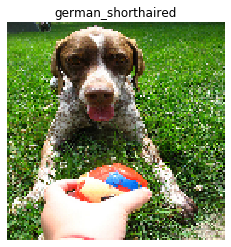

In [ ]:
dec = pets.decode((x,y))
dec.show()

### Try 2: State inside class

We can now create a `Transform` that converts from an index to our `x` and `y` for modeling.

In [ ]:
class PetTfm(Transform):
    def __init__(self, items, train_idx):
        self.items,self.train_idx = items,train_idx
        self.labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
        vals = map(self.labeller, items[train_idx])
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, i):
        o = self.items[i]
        return resized_image(o), self.o2i[self.labeller(o)]
    
    def decodes(self, x)->TitledImage: return x[0],self.vocab[x[1]]

Note the two type annotations:
- encodes has a return type-annotation of `None` which tells the transform to not try propagating the type (i.e. casting the output to the type of the input) but keep whatever we get
- decodes has a return type-annotation with `TitledImage`

It's important to give the type that can show itself to fully decoded elements because when in a `Pipeline`, we stop decoding as soon as we can find a `show` method.

In [ ]:
pets = PetTfm(items, split_idx[0])

In [ ]:
x,y = pets(0)
x.shape,y

(torch.Size([3, 128, 128]), 20)

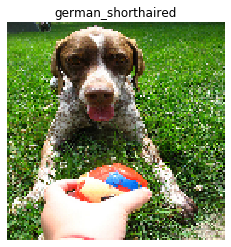

In [ ]:
dec = pets.decode((x,y))
dec.show()

## Using `Pipeline` to create Siamese model dataset

A *Siamese* model needs a dataset with two images as input, and a boolean output that is `True` if the two images are the "same" (e.g. are pictures of the same breed of pet). Custom structures like this are often easiest to create using your own `Pipeline`, which makes no assumptions about the structure of your input or output data.

First we create a SiamesePair that returns a tuple of three things: two image Path and one boolean.

In [ ]:
class SiamesePair(Transform):
    def __init__(self,items,labels):
        self.items,self.labels,self.assoc = items,labels,self
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        # dict of (each unique label) -> (list of indices with that label)
        self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items)
        
    def encodes(self,i)->None:
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        othercls = self.clsmap[self.labels[i]] if random.random()>0.5 else self.idxs
        otherit = random.choice(othercls)
        return (self.items[i], self.items[otherit], self.labels[otherit]==self.labels[i])

Then we want to open and resize the image filenames but not the boolean. This kind of filtering is done with type annotations. We indicated with the return type annotation of `SiamesePair.encodes` the types of our objects and we can then create a new transform that open and resize `Path` objects but leave other types untouched. 

By default a transform is applied on the object it receives. Here, we want the transform that opens and resizes to be applied on each part of the received tuple that is a `Path` object. To do this, we use `as_item_force=False` to force a tuple behavior (it wouldn't be necessary when using `TfmdDS`).

In [ ]:
class OpenAndResize(Transform):
    as_item_force = False
    def encodes(self, x:Path): return resized_image(x)

Then the `Pipeline` will compose our two transforms.

In [ ]:
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
sp = SiamesePair(items, items.mapped(labeller))
pipe = Pipeline([sp, OpenAndResize()])
x,y,z = pipe(0)
x.shape,y.shape,z

(torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), False)

Again, to show this, we need a custom type.

In [ ]:
class SiameseImage(tuple):
    def show(self, ctx=None, **kwargs): 
        return show_image(torch.cat([self[0],self[1]], dim=2), title=self[2], ctx=ctx)
    
    @classmethod
    def create(cls,x): return cls(x)

In [ ]:
pipe = Pipeline([sp, OpenAndResize(), SiameseImage.create])

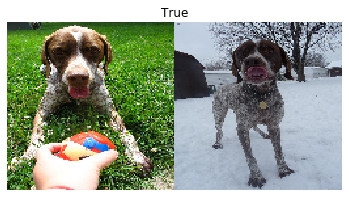

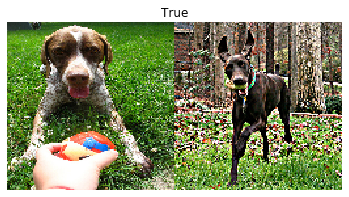

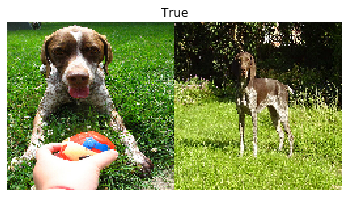

In [ ]:
for _ in range(3): pipe.show(pipe(0))

## Using `TfmdDS`

`TfmdDS` applies a list of list of transforms (or list of `Pipeline`s) lazily to items of a collection, creating one output per list of transforms/`Pipeline`. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. For instance, we could add data augmentation, data normalization, etc. Here we separate out the steps of the basic pets process.

You can additionally add some `ds_tfms` to be applied to the tuple created.

In [ ]:
class ImageResizer(Transform):
    order=10
    "Resize image to `size` using `resample"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

In [ ]:
tfms = [[PILImage.create, ImageResizer(128), ToTensor(), ByteToFloatTensor()],
        [labeller, Categorize()]]
tds = TfmdDS(items, tfms)

In [ ]:
L(tds[0]).mapped(type)

(#2) [<class 'local.data.transform.TensorImage'>,<class 'int'>]

In [ ]:
t = tds[0]
x,y = tds.decode(t)
x.shape,y

(torch.Size([3, 128, 128]), 'german_shorthaired')

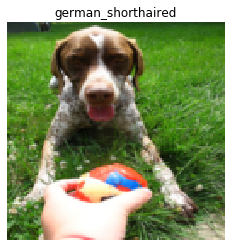

In [ ]:
tds.show(t);

The types being properly propagated and dispatched, we can do the same thing with `ImageResizer`, `ImageToByteTensor`, `ByteToFloatTensor` being passed as tranforms over the tuple.

In [ ]:
tfms = [[PILImage.create], [labeller, Categorize()]]
tds = TfmdDS(items, tfms)
tdl = TfmdDL(tds, bs=1, after_item=[ImageResizer(128), ToTensor(), ByteToFloatTensor()])

In [ ]:
t = tdl.one_batch()
x,y = tdl.decode_batch(t)[0]
x.shape,y

(torch.Size([3, 128, 128]), 'german_shorthaired')

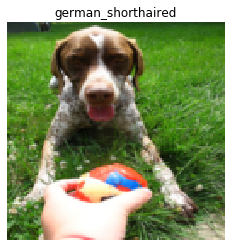

In [ ]:
tds.show((x,y));

## Using `DataSource`

In [ ]:
tfms = [PILImage.create, [labeller, Categorize()]]

To create a `Datasource`, you pass along items, tfms and tuple_tfms like for `TfmdDS` and just add the `filts` indices that represent the split betzeen train and validation set (there can be multiple validation sets).

In [ ]:
pets = DataSource(items, tfms, filts=split_idx)

To access an element we need to specify the subset (either with `train`/`valid` or with `subset(i)`):

In [ ]:
x,y = pets.subset(1)[0]
x.shape,y

((375, 500), 23)

...or equivalently:

In [ ]:
x2,y2 = pets.valid[0]
test_eq(x.shape,x2.shape)
test_eq(y,y2)

We can decode an element for display purposes, either passing a tuple to `decode` or by passing an index to `decode_at`.

In [ ]:
xy = pets.valid.decode((x,y))
xy[1]

'japanese_chin'

In [ ]:
xy2 = pets.valid.decode_at(0)
test_eq(type(xy2[1]), Category)
test_eq(xy2, xy)

We're now ready to show our items.

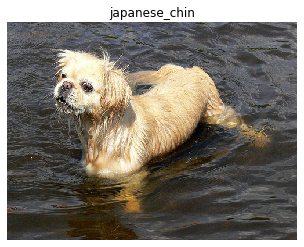

In [ ]:
pets.show((x,y));

We can use this to feed a `DataLoader` and view a batch. It's faster to convert to float on GPU, so we'll do it as a DataLoader transform, after CUDA.

In [ ]:
ds_img_tfms = [ImageResizer(128), ToTensor()]
dl_tfms = [Cuda(), ByteToFloatTensor()]

trn_dl = TfmdDL(pets.train, bs=9, after_item=ds_img_tfms, after_batch=dl_tfms)
b = trn_dl.one_batch()

test_eq(len(b[0]), 9)
test_eq(b[0][0].shape, (3,128,128))
test_eq(b[0].type(), 'torch.cuda.FloatTensor')

In [ ]:
bd = trn_dl.decode_batch(b)

test_eq(len(bd), 9)
test_eq(bd[0][0].shape, (3,128,128))

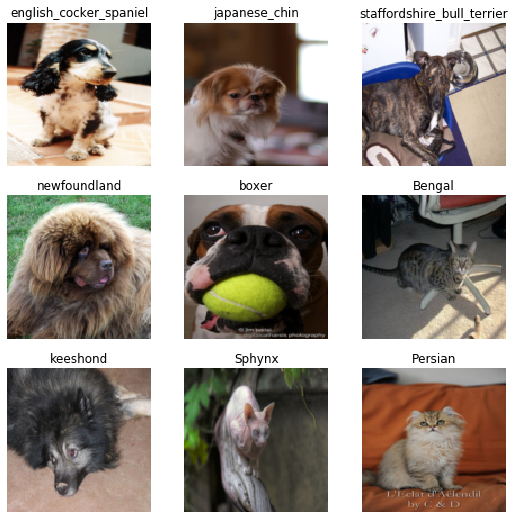

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
trn_dl.show_batch(ctxs=axs.flatten())

## Segmentation

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
tfms = [[PILImage.create], [cv_label, PILMask.create]]
camvid = DataSource(cv_items, tfms, filts=cv_split)
trn_dl = TfmdDL(camvid.train,  bs=4, after_item=ds_img_tfms, after_batch=dl_tfms)

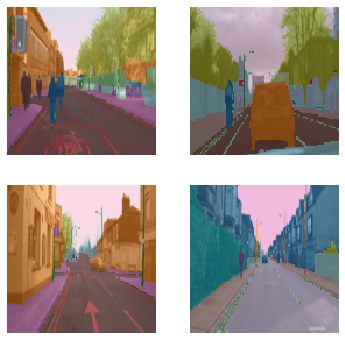

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

## fin -